In [46]:
import numpy as np
import pandas as pd

In [47]:
data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")

# EDA

In [48]:
data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [49]:
data.shape

(7613, 5)

## Initial cleanup

### Handling NaNs

In [50]:
def na_counts(df):
    na_columns = df.columns[df.isna().any()]
    if len(na_columns)==0:
        return 0
    return df[na_columns].isna().apply(lambda x: x.value_counts())

In [51]:
na_counts(data)

,keyword,location
False,7552,5080
True,61,2533


In [52]:
na_counts(test_data)

,keyword,location
False,3237,2158
True,26,1105


In [53]:
data = data.fillna("")
test_data = test_data.fillna("")

In [54]:
na_counts(data), na_counts(test_data)

(0, 0)

## Exploring variables

In [55]:
from sklearn.metrics import mutual_info_score
from sklearn.feature_extraction import DictVectorizer

In [56]:
def sorted_corr_coefs(df, column_name, target_column_name):
    dv = DictVectorizer(sparse=False)
    dict = data[[column_name]].to_dict(orient='records')
    columns = np.transpose(dv.fit_transform(dict))
    corrcoefs = []
    for col in columns:
        corrcoefs.append(np.corrcoef(col, data[target_column_name])[0, 1])
    named_list = list(zip(dv.get_feature_names_out(), corrcoefs))
    named_list.sort(key=lambda tup: tup[1], reverse = True)
    return named_list

In [57]:
# Analyzing mutual info score I want to compare it with such of a shuffled data
shuffled_target = data.target.sample(frac=1, random_state=10)

### Variable "keyword"

In [58]:
data.keyword.value_counts()

                         61
fatalities               45
deluge                   42
armageddon               42
sinking                  41
                         ..
forest%20fire            19
epicentre                12
threat                   11
inundation               10
radiation%20emergency     9
Name: keyword, Length: 222, dtype: int64

In [59]:
mutual_info_score(data['keyword'], data['target']), mutual_info_score(data['keyword'], shuffled_target)

(0.16947295623391556, 0.013396592412637555)

In [60]:
sorted_corr_coefs(data, "keyword", "target")[:30], sorted_corr_coefs(data, "keyword", "target")[-30:]

([('keyword=derailment', 0.08267501656791963),
  ('keyword=wreckage', 0.08267501656791963),
  ('keyword=debris', 0.080516616503906),
  ('keyword=outbreak', 0.08006342865745676),
  ('keyword=typhoon', 0.07783761510564755),
  ('keyword=oil%20spill', 0.0778376151056471),
  ('keyword=suicide%20bombing', 0.07198080078232648),
  ('keyword=suicide%20bomber', 0.0695037416094893),
  ('keyword=suicide%20bomb', 0.06653252563655127),
  ('keyword=rescuers', 0.06653252563655115),
  ('keyword=nuclear%20disaster', 0.06522974951590454),
  ('keyword=evacuated', 0.06394441989331812),
  ('keyword=bombing', 0.06263006921820151),
  ('keyword=razed', 0.06261005839265929),
  ('keyword=wildfire', 0.05986365507855725),
  ('keyword=airplane%20accident', 0.058687591148766684),
  ('keyword=wild%20fires', 0.057003478164473),
  ('keyword=buildings%20on%20fire', 0.05582460651063401),
  ('keyword=mass%20murder', 0.055824606510633965),
  ('keyword=bridge%20collapse', 0.05476512390487407),
  ('keyword=forest%20fires', 0

### Variable "location"

In [61]:
data.location.value_counts()

                                2533
USA                              104
New York                          71
United States                     50
London                            45
                                ... 
Surulere Lagos,Home Of Swagg       1
MontrÌ©al, QuÌ©bec                 1
Montreal                           1
ÌÏT: 6.4682,3.18287                1
Lincoln                            1
Name: location, Length: 3342, dtype: int64

In [62]:
mutual_info_score(data['location'], data['target']), mutual_info_score(data['location'], shuffled_target)

(0.31254635681695697, 0.30151620936968093)

In [63]:
sorted_corr_coefs(data, "location", "target")[:10], sorted_corr_coefs(data, "location", "target")[-10:]

([('location=USA', 0.05101140011993961),
  ('location=Mumbai', 0.047195302822488135),
  ('location=India', 0.045857912019408635),
  ('location=Nigeria', 0.043700694813182915),
  ('location=Washington, DC', 0.030239642046364305),
  ('location=Bend, Oregon', 0.026416230235620966),
  ('location=Nairobi-KENYA', 0.02641623023562073),
  ('location=Calgary', 0.026416230235620723),
  ('location=Nigeria ', 0.02641623023562072),
  ('location=Portland, Oregon', 0.02641623023562072)],
 [('location=Coventry', -0.022250773490737206),
  ('location=Texas, USA', -0.02225077349073725),
  ('location=Indiana', -0.02225077349073729),
  ('location=Wisconsin', -0.02225077349073729),
  ('location=ss', -0.024151501376051914),
  ('location=London, England', -0.024151501376051928),
  ('location=Morioh, Japan', -0.024376103182953163),
  ('location=Pennsylvania, USA', -0.026330931421991832),
  ('location=304', -0.029860396014459598),
  ('location=New York', -0.04004435015466763)])

### Plan

In [64]:
scores = []
def mus_vs_shuffle(df, target_column):
    for column in df.columns:
        if column != target_column:
            shuffled = df[column].sample(frac=1)
            score = mutual_info_score(df[column], df[target_column])
            shuffled_score = mutual_info_score(shuffled, df[target_column])
            scores.append([column, score, shuffled_score])
    return pd.DataFrame(scores, columns=["column", "score", "shuffled_score"])

1 Analyze data
- main properties
    - list of columns
-- how many NaNs per column
-- type of column
-- unique count in column
-- do all steps from all homeworks
1.1 What are the correlations
1.2 How significant
1.3 Find dirt (nas, etc.)
2. Cleanup data
2.1 FillNa
1.3 "Dirty" data
3. Check hypothesis with models
- frequency of some words in the text indicate disaster
- combination of some words in the test indicate disaster
- combination of some words in the text with the keyword
- combination of some words in the text with location
3.1 Models to try out:
- Linear Regression
- Random Forest
- Booster
3.2 

In [65]:
mus_vs_shuffle(clean_data, target_column='target')

NameError: name 'clean_data' is not defined

### Variable "text"

In [66]:
from sklearn import feature_extraction, linear_model, model_selection, preprocessing

##### Count vectorizer does similar thing to usual dict vectorizer. It splits texts into separate words and create a column for each word. Than it assigns a number of occurences for each word in each cell of a particular column. In our case it will be `text`

In [67]:
count_vectorizer = feature_extraction.text.CountVectorizer()
vectors = count_vectorizer.fit_transform(data['text'])
vectors.shape

(7613, 21637)

##### Let's see how the first text look like in terms of words frequencies

In [68]:
frequencies = list(zip(count_vectorizer.get_feature_names_out(), vectors[0].todense().getA()[0]))
[x for x in frequencies if x[1] > 0], data.text[0]

([('all', 1),
  ('allah', 1),
  ('are', 1),
  ('deeds', 1),
  ('earthquake', 1),
  ('forgive', 1),
  ('may', 1),
  ('of', 1),
  ('our', 1),
  ('reason', 1),
  ('the', 1),
  ('this', 1),
  ('us', 1)],
 'Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all')

##### Interesting! There are hashtags, i.e. #earthquake, but they are extracted as simple words. Let's fix this

In [69]:
hashtag_pattern = r'(?u)\b\w\w+\b|#?\w\w+\b'
count_vectorizer = feature_extraction.text.CountVectorizer(token_pattern=hashtag_pattern)
vectors = count_vectorizer.fit_transform(data['text'])
vectors.shape

(7613, 22351)

In [70]:
frequencies = list(zip(count_vectorizer.get_feature_names_out(), vectors[0].todense().getA()[0]))
[x for x in frequencies if x[1] > 0], data.text[0]

([('#earthquake', 1),
  ('all', 1),
  ('allah', 1),
  ('are', 1),
  ('deeds', 1),
  ('forgive', 1),
  ('may', 1),
  ('of', 1),
  ('our', 1),
  ('reason', 1),
  ('the', 1),
  ('this', 1),
  ('us', 1)],
 'Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all')

##### Now let's just have a look at random keywords from the top of the list:

In [71]:
count_vectorizer.get_feature_names_out()[0:100]

array(['#0215', '#034', '#039', '#06', '#09', '#1008pla', '#1008planet',
       '#124', '#140', '#16', '#163', '#17', '#171', '#2015', '#20150613',
       '#22days', '#24', '#263chat', '#2a', '#2fast2furious',
       '#2minutemix', '#360wisenews', '#365disasters', '#37592', '#38745',
       '#3novices', '#452', '#4playthursdays', '#5sosfam', '#615', '#629',
       '#7newsadl', '#8217', '#8392', '#89x', '#911', '#9973', '#999day',
       '#9newsmornings', '#abandoned', '#abbott', '#abc',
       '#abc7eyewitness', '#abcnews', '#abha', '#ableg', '#abomb',
       '#abstorm', '#accident', '#accidentalprophecy', '#acenewsdesk',
       '#achedin', '#act', '#actionmoviestaughtus', '#adani',
       '#addtexastonext1dtour', '#adiossuperbacterias', '#adjust',
       '#adult', '#aeroplane', '#aerospace', '#afc', '#afghanistan',
       '#afp', '#africa', '#africanbaze', '#africansinsf', '#after',
       '#afterhaiyan', '#afterlife', '#aftershock', '#age', '#aids',
       '#aintsheperty', '#aircraft

##### A lot or weird texts looking like some hashes or something. Let's find where one of them occur in the texts

In [72]:
data.loc[data['text'].str.contains("0cxm5tkz8y", case=False)].text.values[0]

'Sharp rise in women children casualties in Afghan war UN says http://t.co/0CXm5TkZ8y http://t.co/v5aMDOvHOT'

##### So these look like parts of urls. Let's check how many different urls we have

In [73]:
url_pattern =  r'(https?:\/\/(?:www\.)?[-a-zA-Z0-9@:%._+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}[-a-zA-Z0-9()@:%_+.~#?&/=]*)'

In [74]:
data.text[data.text.str.findall(url_pattern).apply(len) > 0].values

array(['@bbcmtd Wholesale Markets ablaze http://t.co/lHYXEOHY6C',
       'We always try to bring the heavy. #metal #RT http://t.co/YAo1e0xngw',
       '#AFRICANBAZE: Breaking news:Nigeria flag set ablaze in Aba. http://t.co/2nndBGwyEi',
       ...,
       'Two giant cranes holding a bridge collapse into nearby homes http://t.co/STfMbbZFB5',
       'M1.94 [01:04 UTC]?5km S of Volcano Hawaii. http://t.co/zDtoyd8EbJ',
       'The Latest: More Homes Razed by Northern California Wildfire - ABC News http://t.co/YmY4rSkQ3d'],
      dtype=object)

In [75]:
data.text.str.findall(url_pattern).apply(lambda x: x[0] if len(x) > 0 else None).value_counts()

http://t.co/qew4c5M1xd    9
http://t.co/KSAwlYuX02    6
http://t.co/q2eBlOKeVE    6
http://t.co/vVPLFQv58P    5
http://t.co/cybKsXHF7d    5
                         ..
http://t.co/NXLEiIJFgS    1
http://t.co/y5Yhbb0hkf    1
http://t.co/GedOxSPpL9    1
http://t.co/4k8OLZv9bV    1
http://t.co/YmY4rSkQ3d    1
Name: text, Length: 3875, dtype: int64

##### Probably some of them might be a good indicator of a target. We might want to create a separate column, such as number of urls in a text or something like that

##### Let's observe correlation of different words with target

In [76]:
columns = np.transpose(vectors.todense().A)
columns.shape

(22351, 7613)

In [77]:
corrcoefs = []
for col in columns:
    corrcoefs.append(np.corrcoef(col, data.target)[0, 1])
named_list = list(zip(count_vectorizer.get_feature_names_out(), corrcoefs))
named_list.sort(key=lambda tup: tup[1], reverse = True)

In [78]:
named_list[0:10], named_list[-10:]

([('http', 0.2126857016032362),
  ('co', 0.19572817733727796),
  ('in', 0.1651045693565625),
  ('california', 0.12913544724422837),
  ('suicide', 0.12401359099263466),
  ('killed', 0.11853259856300873),
  ('mh370', 0.10691665675635052),
  ('northern', 0.10608400609185162),
  ('hiroshima', 0.10465394740838699),
  ('after', 0.10165252947420254)],
 [('love', -0.06875973302225376),
  ('can', -0.07132110403337122),
  ('it', -0.07247470509376949),
  ('full', -0.0730178581511043),
  ('so', -0.07517673569508387),
  ('your', -0.07672163676999283),
  ('body', -0.08303134852414512),
  ('me', -0.08871342288840284),
  ('my', -0.12872670360280616),
  ('you', -0.15300123086640835)])

In [79]:
tags_list = list(filter(lambda tup: "#" in tup[0], named_list))
tags_list[:10], tags_list[-10:]

([('#hiroshima', 0.062024958475825245),
  ('#news', 0.059967246136529775),
  ('#earthquake', 0.0576296711740032),
  ('#japan', 0.04382652606782275),
  ('#yyc', 0.04178420487501189),
  ('#india', 0.04178420487501188),
  ('#breaking', 0.03963737068015414),
  ('#worldnews', 0.039637370680154126),
  ('#abstorm', 0.03963737068015392),
  ('#disaster', 0.03736801441379245)],
 [('#ices', -0.026330931421991874),
  ('#trapmusic', -0.026330931421991874),
  ('#animalrescue', -0.02633093142199191),
  ('#edm', -0.028150800356406054),
  ('#dnb', -0.02815080035640607),
  ('#beyhive', -0.02815080035640608),
  ('#fashion', -0.029860396014459552),
  ('#job', -0.0344866190142626),
  ('#nowplaying', -0.03654880702029747),
  ('#jobs', -0.037254707512115647)])

In [80]:
freq_sums = vectors.todense().sum(axis=0).A[0]

In [81]:
named_sums = list(zip(count_vectorizer.get_feature_names_out(), freq_sums))
named_sums = list(filter(lambda tup: tup[1] > 5, named_sums))
print (len(named_sums))
sorted(named_sums, key=lambda tup: tup[1], reverse=True)[0:30]

2399


[('co', 4739),
 ('http', 4309),
 ('the', 3277),
 ('in', 1985),
 ('to', 1949),
 ('of', 1830),
 ('and', 1426),
 ('is', 949),
 ('you', 902),
 ('for', 894),
 ('on', 860),
 ('it', 779),
 ('my', 680),
 ('that', 623),
 ('with', 572),
 ('at', 542),
 ('by', 527),
 ('this', 480),
 ('from', 422),
 ('https', 411),
 ('be', 408),
 ('are', 404),
 ('have', 386),
 ('was', 386),
 ('like', 348),
 ('û_', 348),
 ('amp', 344),
 ('as', 331),
 ('up', 330),
 ('me', 329)]

# Training Models

In [82]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import RidgeClassifier, LogisticRegression
import matplotlib.pyplot as plt 

In [83]:
train_data = data

In [84]:
cv = CountVectorizer()

In [85]:
train_vectors = cv.fit_transform(train_data.text)
all_tokens = train_vectors.shape[1]
all_tokens

21637

In [91]:
model_rc = RidgeClassifier(random_state=42)
model_lr = LogisticRegression(solver="liblinear", C=1.0, max_iter=1000, random_state=42)

scores = model_selection.cross_val_score(model_rc, train_vectors, data["target"], cv=3, scoring="f1")
scores.mean()

0.5999722488858569

In [102]:
def explore_limits(limits, model, min = True, random_state = 42):
    scores = {
        'hashtags': [],
        'plain_words': []
    }
    
    cv = model_selection.StratifiedKFold(4, shuffle=True, random_state=random_state)     
    
    for m in limits:
        plain_cv = CountVectorizer(max_df = m, min_df=85)
        hashtag_cv = CountVectorizer(token_pattern=hashtag_pattern, max_df = m, min_df=85)
        if min:
            plain_cv = CountVectorizer(min_df = m)
            hashtag_cv = CountVectorizer(token_pattern=hashtag_pattern, min_df = m)
        plain_vectors = plain_cv.fit_transform(train_data.text)
        hash_vectors = hashtag_cv.fit_transform(train_data.text)
        scores['hashtags'].append(model_selection.cross_val_score(model, hash_vectors, data["target"], cv=cv, scoring="f1").mean())
        scores['plain_words'].append(model_selection.cross_val_score(model, plain_vectors, data["target"], cv=cv, scoring="f1").mean())

    plt.plot(limits, scores['hashtags'], label='Hashtags')
    plt.plot(limits, scores['plain_words'], label='Plain words')
    if min:
        plt.ylabel("min_df")
    else:
        plt.ylabel("max_df")
    plt.xlabel("limits")
    plt.legend()
    print (list(zip(limits, scores)))

[(1, 'hashtags'), (101, 'plain_words')]


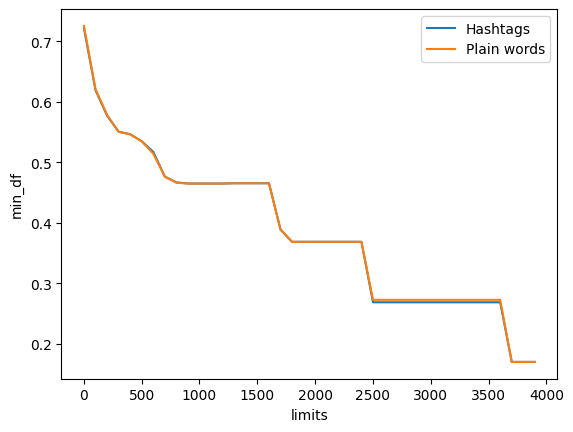

In [103]:
explore_limits(list(range(1, 4000, 100)), model_rc, random_state=2)

[(1, 'hashtags'), (101, 'plain_words')]


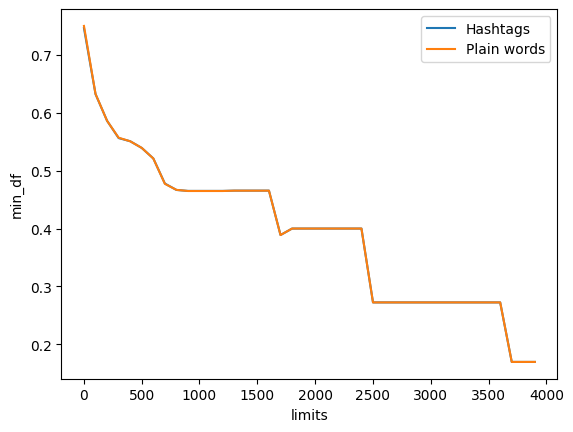

In [104]:
explore_limits(list(range(1, 4000, 100)), model_lr, random_state=2)

[(0, 'hashtags'), (1, 'plain_words')]


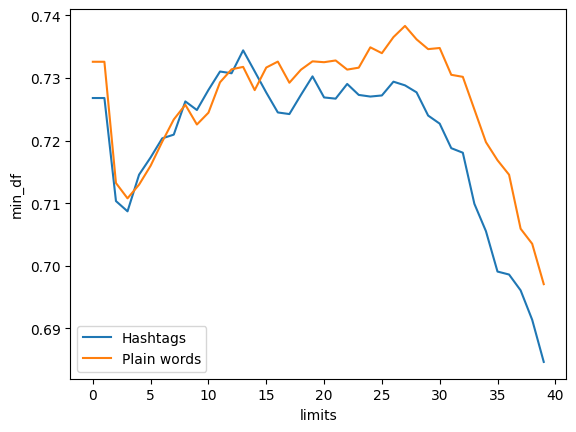

In [105]:
explore_limits(list(range(0, 40, 1)), model_rc, random_state=5)

[(0, 'hashtags'), (1, 'plain_words')]


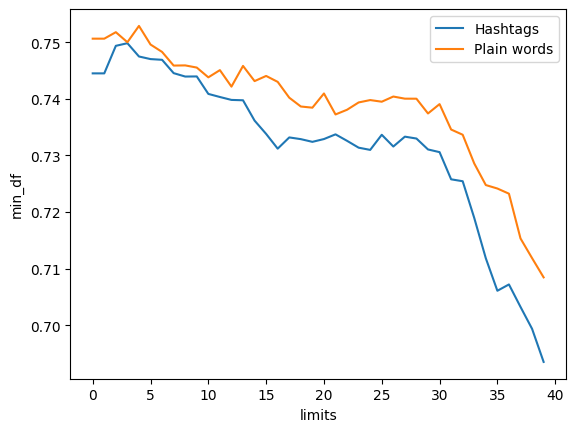

In [106]:
explore_limits(list(range(0, 40, 1)), model_lr, random_state=5)

[(85, 'hashtags'), (185, 'plain_words')]


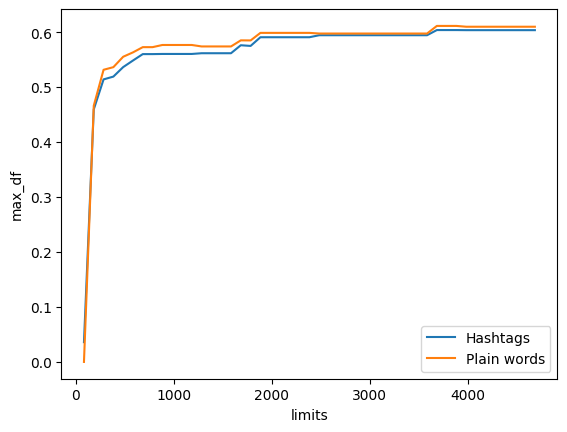

In [769]:
explore_rc_limits(list(range(85, 4739, 100)), min=False)

[(3600, 'hashtags'), (3615, 'plain_words')]


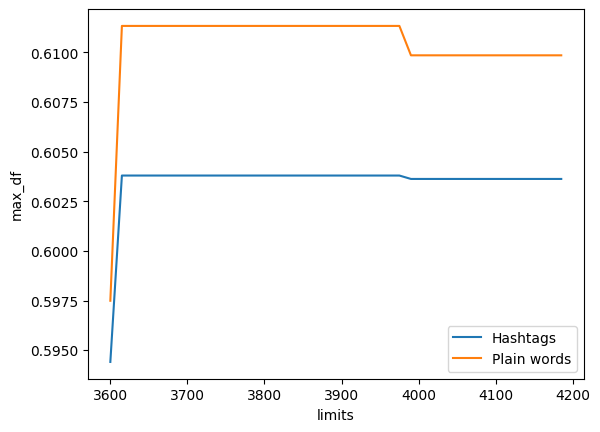

In [770]:
explore_rc_limits(list(range(3600, 4200, 15)), min=False)

In [771]:
def heatmap_rc_limits(limits, min = True):
    scores = []
    for m in limits:
        cv = CountVectorizer(max_df = m)
        if min:
            cv = CountVectorizer(min_df = m)
        train_vectors = cv.fit_transform(train_data.text)
        scores.append(model_selection.cross_val_score(model_rc, train_vectors, data["target"], cv=5, scoring="f1").mean())
    plt.plot(limits, scores)
    if min:
        plt.ylabel("min_df")
    else:
        plt.ylabel("max_df")
    plt.xlabel("limits")
    print (list(zip(limits, scores)))

In [772]:
cv = CountVectorizer(min_df = 85)
vectors = cv.fit_transform(train_data.text)
model_selection.cross_val_score(model_rc, vectors, data["target"], cv=4, scoring="f1").mean()

0.616637728194334

### Trying with adding the "keyword" column

In [814]:
import scipy.sparse as sp
from sklearn.feature_selection import SelectKBest, chi2

In [821]:
dv = DictVectorizer()
dict = data[['keyword']].to_dict(orient='records')
keyword_vectors = dv.fit_transform(dict)
keyword_vectors.shape

(7613, 222)

In [822]:
vectors.shape

(7613, 132)

In [823]:
type(keyword_vectors)

scipy.sparse._csr.csr_matrix

In [824]:
support = SelectKBest(k=5).fit(keyword_vectors, data.target)
dv.restrict(support.get_support())
dv.get_feature_names_out()
support.get_support()

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
        True, False, False, False, False, False, False, False,  True,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [825]:
dv.transform(dict)

<7613x5 sparse matrix of type '<class 'numpy.float64'>'
	with 193 stored elements in Compressed Sparse Row format>

In [852]:
scores = []
feature = 'keyword';
limits = list(range(1, data[feature].nunique(), 5))
dict = data[[feature]].to_dict(orient='records')

cv = model_selection.StratifiedKFold(3, shuffle=True, random_state=6) 
for i in limits:
    keyword_vectors = dv.fit_transform(dict)
    support = SelectKBest(k=i).fit(keyword_vectors, data.target)
    dv.restrict(support.get_support())
    combined_vectors = sp.hstack((vectors, dv.transform(dict)))
    s = model_selection.cross_val_score(model_rc, combined_vectors, data["target"], cv=cv, scoring="f1").mean()
    scores.append(s)

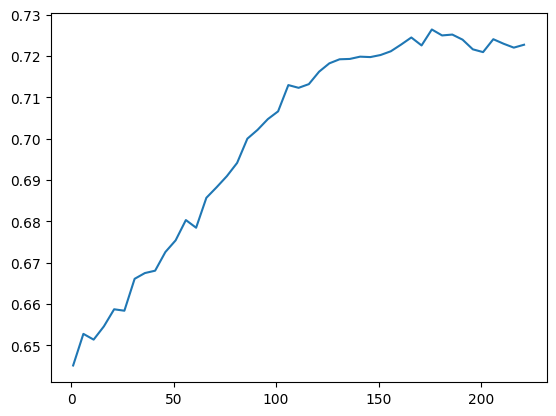

In [853]:
plt.plot(limits, scores)

In [790]:
model_selection.cross_val_score(model_rc, combined_vectors, data["target"], cv=4, scoring="f1").mean()

0.6141695178825801